In [11]:
from helper_models import RuleClassifier
import util
from difference_models import BinaryDifferenceClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import cloudpickle
%matplotlib inline

This is based on scikit-learn example [Logistic function](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py)

In [2]:
try:
    with open('dataset.pickle', 'rb') as f:
        X, y, feature_names, n_features, n_samples = pickle.load(f)
        print('Loaded cached dataset')
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


## Generate Data

In [4]:
decision_rule = lambda x: abs(x[0]) < 0.5

In [5]:
feature_names = ['x1', 'x2']
n_features = 2
xx, yy = np.mgrid[-1:1:30j, -1:1:30j]
X = np.vstack([xx.ravel(), yy.ravel()]).T
n_samples = X.shape[0]
y = np.array([decision_rule(x) for x in X])
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

## Train Models

In [6]:
clf_a = RuleClassifier(decision_rule=decision_rule)
clf_a.fit(X, y)
clf_b = RuleClassifier(decision_rule=lambda x: abs(x[0] + 0.1) < 0.5)
clf_b.fit(X, y)
with open('classifiers.pickle', 'wb') as f:
    cloudpickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

## Analyze Results

## Visualize Distributions of Predictions

In [12]:
z = y
mesh_step_size = .01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))

colors_lower_half = plt.cm.winter(np.linspace(0,1.,128)) 
colors_upper_half = plt.cm.autumn.reversed()(np.linspace(0,1.,128)) 
colors = list(zip(np.linspace(0,0.5,128), colors_lower_half)) + list(zip(np.linspace(0.5,1,128), colors_upper_half))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', colors)
    
def plot(predict_functions, names, zlim=(0, 1)):
    levels = np.linspace(zlim[0], zlim[1], 21)
    fig, axs = plt.subplots(1, len(predict_functions), sharex=True, sharey=True, figsize=(len(predict_functions) * 9, 7))
    for name, predict, ax in zip(names, predict_functions, axs):
        Z = predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = ax.contourf(xx, yy, Z, levels, cmap=cmap, alpha=.8)
        fig.colorbar(cs, ax=ax, shrink=0.9)
        color = ['r' if _y else 'b' for _y in y]
        ax.scatter(X[:, 0], X[:, 1], c=color, vmin=zlim[0], vmax=zlim[1], edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[1])
        ax.set_title(name)

In [13]:
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)

BinaryDifferenceClassifier(clf_a=RuleClassifier(decision_rule=<function <lambda> at 0x11ad7ed30>),
                           clf_b=RuleClassifier(decision_rule=<function <lambda> at 0x11ad7ee50>))

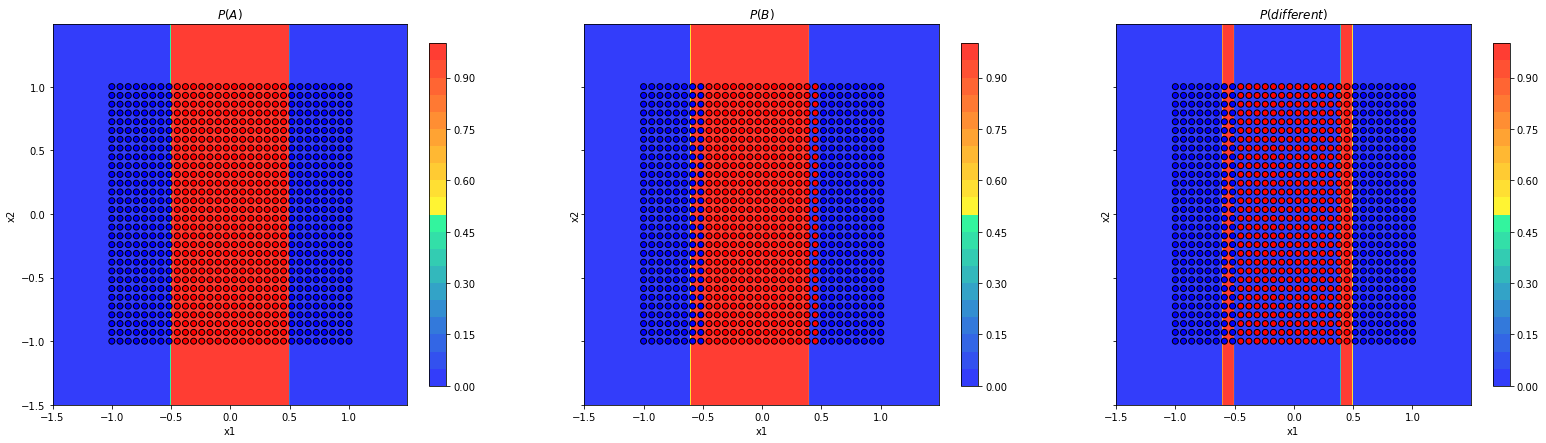

In [14]:
predict_proba_a = lambda X: clf_a.predict_proba(X)[:, 1]
predict_proba_b = lambda X: clf_b.predict_proba(X)[:, 1]
predict_proba_diff = lambda X: binary_diff_clf.predict_proba(X)[:, 0]
plot((predict_proba_a, predict_proba_b, predict_proba_diff), ('$P(A)$', '$P(B)$', '$P(different)$'))